# Kesten Processes and Firm Dynamics

Seho Jeong, Sogang University

In [14]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax
import quantecon as qe
from quantecon import tic, toc

import matplotlib.pyplot as plt

from typing import NamedTuple
from functools import partial

In [2]:
class Firm(NamedTuple):
    μ_a: float = -0.5
    σ_a: float = 0.1
    μ_b: float = 0.0
    σ_b: float = 0.5
    μ_e: float = 0.5
    σ_e: float = 0.5
    s_bar: float = 1.0

In [3]:
# Update a cross-section of firms.
@jax.jit
def update_cross_section(s, a, b, e, firm):
    μ_a, σ_a, μ_b, σ_b, μ_e, σ_e, s_bar = firm
    s = jnp.where(s < s_bar, e, a * s + b)
    return s

In [6]:
def generate_cross_section(firm, M=500_000, T=500, s_init=1.0, seed=123):
    μ_a, σ_a, μ_b, σ_b, μ_e, σ_e, s_bar = firm
    key = random.PRNGKey(seed)

    # Initialize the cross-section to a common value.
    s = jnp.full((M, ), s_init)

    # Perform updates on s for time t.
    for t in range(T):
        key, *subkeys = random.split(key, 4)
        a = μ_a + σ_a * random.normal(subkeys[0], (M, ))
        b = μ_b + σ_b * random.normal(subkeys[1], (M, ))
        e = μ_e + σ_e * random.normal(subkeys[2], (M, ))

        # Exponentiate shocks.
        a, b, e = jax.tree.map(jnp.exp, (a, b, e))

        # Update the cross-section of firms.
        s = update_cross_section(s, a, b, e, firm)
    
    return s

In [12]:
firm = Firm()
tic()
data = generate_cross_section(firm).block_until_ready()
toc()

TOC: Elapsed: 0:00:2.16


2.1664319038391113

In [20]:
@jax.jit
def generate_cross_section_lax(firm, T=500, M=500_000, s_init=1.0, seed=123):
    μ_a, σ_a, μ_b, σ_b, μ_e, σ_e, s_bar = firm
    key = random.PRNGKey(seed)

    # Initiate cross section.
    s = jnp.full((M, ), s_init)

    def update_cross_section(t, state):
        s, key = state
        key, *subkeys = jax.random.split(key, 4)

        # Generate current random draws.
        a = μ_a + σ_a * random.normal(subkeys[0], (M, ))
        b = μ_b + σ_b * random.normal(subkeys[1], (M, ))
        e = μ_e + σ_e * random.normal(subkeys[2], (M, ))

        # Exponentiate them.
        a, b, e = jax.tree.map(jnp.exp, (a, b, e))

        # Pull out the t-th cross-section of shocks.
        s = jnp.where(s < s_bar, e, a * s + b)
        new_state = s, key
        return new_state
    
    # Use fori_loop.
    initial_state = s, key
    final_s, final_key = lax.fori_loop(0, T, update_cross_section, initial_state)

    return final_s

In [23]:
tic()
data = generate_cross_section_lax(firm).block_until_ready()
toc()

TOC: Elapsed: 0:00:2.24


2.2417409420013428

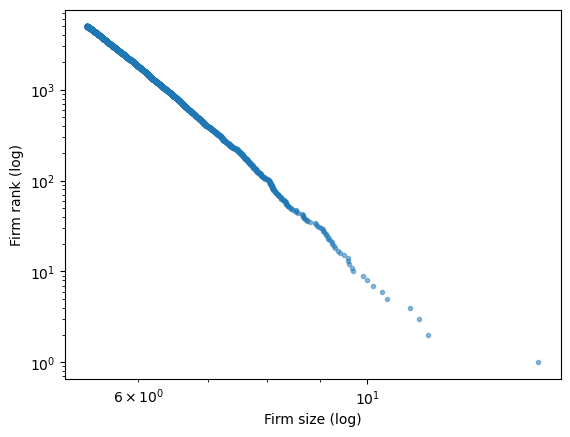

In [24]:
# Draw the rank-size plot and check the distribution.
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(data, c=0.01)

ax.loglog(size_data, rank_data, 'o', markersize=3.0, alpha=0.5)

ax.set_xlabel('Firm size (log)')
ax.set_ylabel('Firm rank (log)')

plt.show()

In [25]:
# An alternative version of `generate_cross_section_lax()` where the entire sequence of random draws is generated at once.
def generate_cross_section_all_at_once(firm, T=500, M=500_000, s_init=1.0, seed=123):
    μ_a, σ_a, μ_b, σ_b, μ_e, σ_e, s_bar = firm
    key = random.PRNGKey(seed)
    subkey1, subkey2, subkey3 = random.split(key, 3)

    # Initiate cross section.
    s = jnp.full((M, ), s_init)

    # Generate entire sequence of random draws.
    a = μ_a + σ_a * random.normal(subkey1, (T, M))
    b = μ_b + σ_b * random.normal(subkey2, (T, M))
    e = μ_e + σ_e * random.normal(subkey3, (T, M))

    # Exponentiate them.
    a, b, e = jax.tree.map(jnp.exp, (a, b, e))

    def update_cross_section(t, state):
        # Pull out the t-th cross-section of shocks.
        a_t, b_t, e_t = a[t], b[t], e[t]
        state_new = jnp.where(state < s_bar, e_t, a_t * s + b_t)
        return state_new
    
    # Use lax.scan to perform the calculations on all states.
    s_final = lax.fori_loop(0, T, update_cross_section, s)
    
    return s_final

In [27]:
tic()
data = generate_cross_section_all_at_once(firm).block_until_ready()
toc()

TOC: Elapsed: 0:00:1.72


1.7271697521209717

This method might or might not be faster. In general, the relative speed will depend on the size of the cross-section and the length of the simulation paths. However, this method is far more memory intensive. It will fail when $T$ and $M$ become sufficiently large.